<img src="images/ublogo.png"/>

### CSE610 - Bayesian Non-parametric Machine Learning

  - Lecture Notes
  - Instructor - Varun Chandola
  - Term - Fall 2020

### Objective
The objective of this notebook is to discuss the model selection and adaptation of hyper-parameters for GP based methods.

<div class="alert alert-info">

**Note:** This material is based on Chapter 5 of the GPML book.

</div>

## How to choose the best model?
The first question is, what are the ingredients of a GP model. Generally speaking, it is the choice of the kernel and its hyper-parameters. There is an additional matter of choosing the noise term in the GPR likelihood model (recall, $y = f({\bf x}) + \epsilon, \epsilon \in \mathcal{N}(0,\sigma^2_n)$).

For instance, a general form of SE function can be expressed as:
$$
k({\bf x},{\bf x}') = \sigma^2_f\exp{(-\frac{1}{2}({\bf x}-{\bf x}')^\top M ({\bf x}-{\bf x}'))}
$$
where $M$ is a square symmetric matrix. If $M$ is $\frac{1}{l} I$, then the above expression reduces to the SE function that was introduced in the previous weeks. However, one can use other forms of $M$, e.g., $M = diag(\frac{1}{\bf l})$ or $M = \Lambda\Lambda^\top + diag(\frac{1}{\bf l})$, where ${\bf l}$ is a $D$ length vector of positive values.
> While we usually use a single $l$ in the SE function, using a vector ${\bf l}$ has some advantages, for instance, understanding the importance of each feature. Also known as *em  Automatic Relevance Determination* or ARD, since the inverse of length-scale determines how relevant each feature is. The third form (with the $\Lambda$) performs a factor analyis along with the GP, using a lower-rank ($D \times p$) matrix $\Lambda$.

In [1]:
%run Utilities.ipynb

 /Users/chandola/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:The sklearn.datasets.openml module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.


In [2]:
def SE(X1, L,X2=None,sigma2f=1):
    K = np.zeros((X1.shape[0],X1.shape[0]))
    if X2 == None:
        X2 = X1
    for i in range(X1.shape[0]):
        for j in range(i,X2.shape[0]):
            d = (X1[i] - X2[j]).T
            K[i,j] = sigma2f*np.exp(-0.5*np.dot(np.dot(d.T,L),d))
            K[j,i] = K[i,j]
    return K


In [3]:
x1s = np.linspace(-2, 2, 40)
x2s = np.linspace(-2, 2, 40)
X1g, X2g = np.meshgrid(x1s, x2s)
X = np.vstack([X1g.flatten(),X2g.flatten()]).T
means = np.zeros((X.shape[0],1)) # assuming a zero mean-function

In [7]:
L1 = 2*np.eye(X.shape[1])
K1 = SE(X,L1)
L2 = np.diag(np.array([0.1,6]))
K2 = SE(X,L2)
Lambda = np.array([[1,-1]])
L3 = np.dot(Lambda.T,Lambda) + np.diag(np.array([1/36,1/36]))
K3 = SE(X,L3)

In [10]:
# Draw a sample from the prior
samples1 = np.random.multivariate_normal(means.ravel(),K1,1)
F1 = samples1.reshape(X1g.shape)
samples2 = np.random.multivariate_normal(means.ravel(),K2,1)
F2 = samples2.reshape(X1g.shape)
samples3 = np.random.multivariate_normal(means.ravel(),K3,1)
F3 = samples3.reshape(X1g.shape)

In [16]:
cs = 'Rainbow'
fig = go.Figure(data=[go.Surface(z=F1, x=X1g, y=X2g,
                                 contours = {"x": {"show": True},
                                             "y": {"show": True}
                                            },
                                 showscale=False,
                                 colorscale=cs
                                )])
fig.update_traces(contours_x=dict(show=True, usecolormap=True,project_x=True))
fig.update_traces(contours_y=dict(show=True, usecolormap=True,project_y=True))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,project_z=True))
fig.update_layout(title='Single lengthscale', autosize=False,
                  width=500, height=500,
                  scene = dict(zaxis=dict(range=[-3,3])),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

fig = go.Figure(data=[go.Surface(z=F2, x=X1g, y=X2g,
                                 contours = {"x": {"show": True},
                                             "y": {"show": True}
                                            },
                                 showscale=False,
                                 colorscale=cs
                                )])
fig.update_traces(contours_x=dict(show=True, usecolormap=True,project_x=True))
fig.update_traces(contours_y=dict(show=True, usecolormap=True,project_y=True))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,project_z=True))
fig.update_layout(title='ARD', autosize=False,
                  width=500, height=500,
                  scene = dict(zaxis=dict(range=[-3,3])),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

fig = go.Figure(data=[go.Surface(z=F3, x=X1g, y=X2g,
                                 contours = {"x": {"show": True},
                                             "y": {"show": True}
                                            },
                                 showscale=False,
                                 colorscale=cs
                                )])
fig.update_traces(contours_x=dict(show=True, usecolormap=True,project_x=True))
fig.update_traces(contours_y=dict(show=True, usecolormap=True,project_y=True))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,project_z=True))
fig.update_layout(title='Factor Analysis', autosize=False,
                  width=500, height=500,
                  scene = dict(zaxis=dict(range=[-3,3])),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

### Back to the model selection problem
For the SE function, as shown above, the model selection problem would involve identifying all the *free* hyperparameters. 

### Model selection in machine learning
Consider a regression problem where you are trying to learn a neural network model. Model selection involves learning the parameters - weights for the neural units (collectively denoted  by ${\bf w}$), and the neural network structure (denoted by $\mathcal{H}$). Given a certain structure, $\mathcal{H}_i$, the weights are learned by minimizing an error function using the training data.

Finding the optimal structure, however, is trickier, particularly because the mathematical relations between then objective function and the structure parameters is not analytically tractable. So typically we resort to an empirical methodology such as **cross-validation**.

### Model selection with Gaussian processes

For GPs, we do not worry about the model parameters, those are replaced by the latent function values, ${\bf f}$. However, we still need to learn the kernel hyper-parameters and the appropriate kernel. The kernel hyper-parameters can be learn by maximizing the marginal likelihood of the training data. 

#### Marginal likelihood Maximization
$$
\log{p({\bf y}\vert X,\theta)} = \underbrace{-\frac{1}{2}{\bf y}^\top (K + \sigma_n^2I)^{-1}{\bf y}}_{\text{data fit}} - \underbrace{\frac{1}{2}\log{\vert K + \sigma_n^2I\vert}}_{\text{complexity}} - \underbrace{\frac{N}{2}\log{2\pi}}_{\text{normalization}}
$$
The above result can be derived by noting that the $i^{th}$ entry in the target vector ${\bf y}$ is a Gaussian random variable with mean as $f_i$ (or $f({\bf x}_i$) and variance as $\sigma_n^2$, and all the latent functions values (collectively denoted as the vector ${\bf f}$) is a sample from a multivariate Gaussian distribution, whose mean is 0 (we are still working with zero-mean function in GP) and the covariance matrix is $K$.

The most obvious way of maximizing the above objective function is to apply a gradient based method, e.g., gradient descent, where we calculate the partial derivative of the above function with respect to every hyperparameter, $\theta_j$, and then using the resulting gradient to update the hyperparameter estimates until convergence.

> The derivations for the gradient will be shown in class

#### Cross-validation
We can also use *leave-one-out cross-validation* (LOO) for learning the optimal hyper-parameters.
> Question: Why would this be desirable over maximizing the marginalized likelihood?

The predictive log probability when leaving out the $i^{th}$ training example would be:
$$
\log{p(y_i \vert X,{\bf y}_{-i}, \theta)} = -\frac{1}{2}\log\sigma_i^2 - \frac{(y_i - \mu_i)^2)}{2\sigma^2_i} - \frac{1}{2}\log{2\pi}
$$
where the notation ${\bf y}_{-i}$ means all entries except for the $i^{th}$ entry and the terms $\mu_i$ and $\sigma_i^2$ are the predictive mean and variance obtained for the $i^{th}$ example using the standard GPR equations.
\begin{eqnarray}
\mu_i & = & {\bf k}_i^\top(K_{-i} + \sigma_n^2I_{-i})^{-1}{\bf y}_{-i}\\
\sigma_i^2 & = & k({\bf x}_i,{\bf x}_i) - {\bf k}_i^\top(K_{-i} + \sigma_n^2I_{-i})^{-1}{\bf k}_i
\end{eqnarray}

The LOO log-likelihood predictive probability (sometimes also called the log *pseudo*-likelihood) will be:
$$
L_{LOO}(X,{\bf y},\theta) = \sum_{i=1}^N \log{p(y_i\vert X,{\bf y}_{-i},\theta)}
$$
It might appear that the LOO process would be much more inefficient than using marginal log-likelihood process if we have to solve the GPR regression $N$ times, for different kernel matrices. However, it turns out that the LOO-CV predictive mean and variance can be estimated very efficiently by computing the inverse of the full covariance matrix, $K$, just once, using the following equations:
$$
\mu_i = y_i - \frac{[K^{-1}{\bf y}]_i}{[K^{-1}]_{ii}}
$$
$$
\sigma^2_i = \frac{1}{[K^{-1}]_{ii}}
$$
One can then compute the partial derivatives of the LOO-CV log-likelihood with respect to the different hyper-parameters, similar to how it was done for marginal log-likelihood maximization.

### Example - Mauna Loa Data set

In [111]:
X,y = load_mauna_loa_atmospheric_co2()


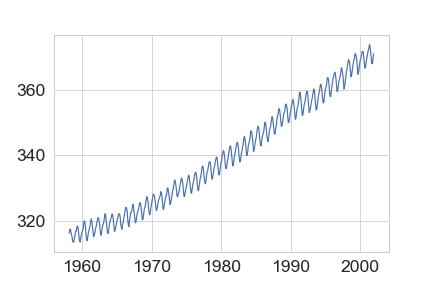

In [112]:
plt.plot(X,y)

In [124]:
k1 = GPy.kern.RBF(1)
k2 = GPy.kern.Prod([GPy.kern.StdPeriodic(1),GPy.kern.RBF(1)])
k3 = GPy.kern.RatQuad(1)
k4 = GPy.kern.RBF(1) + GPy.kern.White(1)

k =  GPy.kern.Add([k1.copy(),k2.copy(),k3.copy(),k4.copy()])
md = GPy.models.GPRegression(X,y[:,np.newaxis],kernel=k,noise_var=1e-3)



In [128]:
GPy.kern.Linear(1)

linear.,value,constraints,priors
variances,1.0,+ve,


In [119]:
md.optimize(messages=True)

In [115]:
md

GP_regression.,value,constraints,priors
sum.rbf.variance,2.1012021494569855e-05,+ve,
sum.rbf.lengthscale,25.137554682663563,+ve,
sum.mul.std_periodic.variance,157.8515074079894,+ve,
sum.mul.std_periodic.period,0.05029592450255157,+ve,
sum.mul.std_periodic.lengthscale,32.20834945114543,+ve,
sum.mul.rbf.variance,157.8515074079908,+ve,
sum.mul.rbf.lengthscale,87.51812827615744,+ve,
sum.RatQuad.variance,1.761536469938715e-08,+ve,
sum.RatQuad.lengthscale,0.024674307433993955,+ve,
sum.RatQuad.power,0.019087989777548903,+ve,
